In [1]:
'''
predict with lstm
total data samples: 20595 , testing data samples: 4199
'''
import torch
import pandas as pd
import os
import numpy as np
import torch.utils.data as data
data_raw = pd.read_csv('./result/v0_road_status.csv', index_col=None)
# data_raw
'''
process data
data_raw: (20609,2)
data_sliced: (20550,10,2)

total: 17473/20550= 0.85
'''
split= 0.2
seq_len = 5  ## window size, the number of time sequence frames
feature_num= data_raw.shape[1]
forward_len = 1 ## means how far it predict, E.G. 60 means 2 secs.
stride = 1
X=[]
y=[]
for i in range(0,data_raw.shape[0]-(forward_len+seq_len), stride):
    X.append(data_raw.iloc[i:i+seq_len,:])
    y.append(data_raw.iloc[i+forward_len+seq_len,0])
X=np.array(X)
y=np.array(y)

# ## last 30% as test 6057/6165= 0.98
# X_train = torch.Tensor(X[:int((1-split)*X.shape[0]),:])
# X_test = torch.Tensor(X[-int((1-split)*X.shape[0]):,:])
# y_train = torch.Tensor(y[:int((1-split)*y.shape[0])])
# y_test = torch.Tensor(y[-int((1-split)*y.shape[0]):])

# first 30% as test,  5433/6165=0.88
X_train = torch.Tensor(X[int(split*X.shape[0]):,:])
y_train = torch.Tensor(y[int(split*y.shape[0]):])

X_test = torch.Tensor(X[:int(split*X.shape[0])-1,:])
y_test = torch.Tensor(y[:int(split*y.shape[0])-1])


In [4]:
import torch
import torch.nn as nn
from torchsummary import summary
class LSTM_model(nn.Module): ## lr=0.001, epoch=20
    def __init__(self):
        super(LSTM_model,self).__init__()
       
        self.lstm2 = nn.LSTM(2, 64, 1, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(64, 16, 1, batch_first=True, dropout=0.2)
        self.out = nn.Linear(16,1)

    def forward(self,x):
        '''
            h0(num_layers * num_directions, batch, hidden_size), e.g. (1,10,128)
            c0(num_layers * num_directions, batch, hidden_size)
        '''

        r_out, (hn2, cn2) = self.lstm2(x)
        r_out, _ = self.lstm3(r_out)

        '''
        output after lstm3: (batch_size, sequence_length, num_hidden_units), 
        where batch_size is the number of sequences in the batch, 
        sequence_length is the length of each input sequence, 
        and num_hidden_units is the number of hidden units in the LSTM layer.
        '''
        

        r_out = r_out[:,-1,:]  ##take the last one in the output sequence        
        out = nn.functional.relu(r_out)
        out = self.out (out)
        return torch.sigmoid(out)
model= LSTM_model()
model

/home/royliu/Downloads/yes/envs/py310/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_model(
  (lstm2): LSTM(2, 64, batch_first=True, dropout=0.2)
  (lstm3): LSTM(64, 16, batch_first=True, dropout=0.2)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [2]:
import torch.optim as optim
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

device ='cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
n_epochs= 5
threshold = 0.5
loader =  data.DataLoader(data.TensorDataset(X_train, y_train), shuffle= False, batch_size =8)
for epoch in range(n_epochs):
    model.train().to(device)
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_prob= model(X_batch)[:,0]  ## shape(8,1) to shape(8,)
        print(y_pred_prob)
        loss = loss_fn(y_pred_prob, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.eval().to(device)
    with torch.no_grad():
        print(type(X_train), X.shape)
        y_pred_prob = model(X_train.to(device)).cpu()[:,0]  ## in cpu, shape(xxxx,1) to shape(xxxx,)
        train_rmse= np.sqrt(loss_fn(y_pred_prob, y_train))
        y_pred = [1 if y_pred_prob[j] > threshold else 0 for j in range(y_pred_prob.shape[0])]
        y_target= y_train
        acc = accuracy_score(y_target, y_pred)
        f1 = f1_score(y_target, y_pred)
        recall = recall_score(y_target, y_pred)
        precision = precision_score(y_target, y_pred)
  
        y_pred_prob = model(X_test.to(device)).cpu()[:,0]  ## in cpu, , shape(yyyy,1) to shape(yyyy,)
        val_rmse = np.sqrt(loss_fn(y_pred_prob, y_test))
        y_pred = [1 if y_pred_prob[j] > threshold else 0 for j in range(y_pred_prob.shape[0])]
        y_target= y_test
        acc = accuracy_score(y_target, y_pred)
        f1 = f1_score(y_target, y_pred)
        recall = recall_score(y_target, y_pred)
        precision = precision_score(y_target, y_pred)
        print(f'Validation data:: Acc: {acc}, f1: {f1}, recall: {recall}, precision: {precision}')
    
    print(f"Epoch {epoch}: validation RMSE: {train_rmse} , validation RMSE: {val_rmse}.")

100%|█████████████████████████████████████| 4119/4119 [00:01<00:00, 2220.75it/s]


sklearn Acc: 0.995630, Recall: 0.997379, Precision: 0.997902, F1: 0.997641 


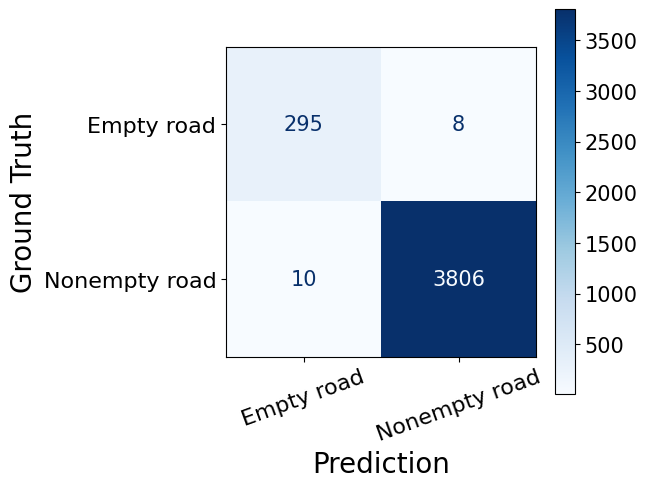

In [11]:
## plot
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

threshold = 0.5

def get_predictions(model, X_test, device):
    model.eval().to(device)
    preds = []
    with torch.no_grad():
        for X in tqdm(X_test):  
            X = X.unsqueeze(dim=0).to(device) ## torch, size of (1, 10, 2)
            y_pred_prob = model(X)[:,0].detach().cpu().item() ## shape(8,1) to shape(8,)
            y_pred = 1 if (y_pred_prob > threshold) else 0

            preds.append(y_pred)
    return preds

def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20, fontsize=16)
    plt.yticks( fontsize=16)
    ax.set_xlabel('Prediction',fontsize=20);ax.set_ylabel('Ground Truth',fontsize=20)
    plt.rcParams.update({'font.size': 15}) ## change the font size in matrix
    plt.show()
    plot_dir = '../result/' 
#     cm.figure_.savefig(plot_dir+'confusion_matrix_lstm.pdf',bbox_inches='tight')

classes = ['Empty road', 'Nonempty road']
preds = get_predictions(model, X_test, device)
labels = y_test
print('sklearn Acc: %f, Recall: %f, Precision: %F, F1: %f '% (accuracy_score(labels, preds),\
    recall_score(labels, preds), precision_score(labels, preds), f1_score(labels, preds)))
plot_confusion_matrix(labels, preds, classes)
